In [1]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import random
from tqdm import tqdm
import statistics
import enum

import urllib.request
import pickle

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, SpatialDropout2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

tf.keras.backend.set_floatx('float64')

Using TensorFlow backend.


In [2]:
def data_retriever(final, download = False):
    '''
    V1.0
    Function to load in the h5py files
    inputs: final(The number of notebooks you wish to load)
            download(boolean to check if user wishes to download the files 
                    or load from directory. False by default)
    outputs:labels (The interaction data as a numpy array)
            maps(The image data as a numpy array)
    
    V2.0
    Function to load in the h5py files
    inputs: final(The number of notebooks you wish to load)
    outputs:labels (The interaction data as a numpy array)
            maps(The image data as a numpy array)
            nu_e(Neutrino energies as a numpy array)
            lep_e(Lepton energies as a numpy array)
    '''
    f_name=[]

    for i in tqdm(range(1,final)):
        file_name = 'test_file ('+str(i)+').h5'
            
        df=h5py.File(file_name,'r') #load file
        
        label = df['rec.training.trainingdata'].get('interaction')
        image = df.get('rec.training.cvnmaps').get('cvnmap')
        nu_energy = df['rec.training.trainingdata'].get('nuenergy')
        lep_energy = df['rec.training.trainingdata'].get('lepenergy')

        if i == 1: # initialises arrays
            
            labels = label[()] #returns label in the form of a np.array
            maps = image[()] #returns image in the form of a np.array
            nu_e = nu_energy[()] #returns neutrino energies in the form of a np.array
            lep_e = lep_energy[()] #returns lepton energies in the form of a np.array

        elif i > 1: 
            
            labels = np.append(labels, label, axis =0)
            maps = np.append(maps, image, axis = 0)
            nu_e = np.append(nu_e, nu_energy, axis = 0)
            lep_e = np.append(lep_e, lep_energy, axis = 0)

    maps = maps.reshape((maps.shape[0],2,100,80))
  
    return labels, maps, nu_e, lep_e

def osc_inten(maps, core_labels, nu_e, lep_e):
    '''
    V1.0:
    Redistributes labels to get 50/50 0s and 1s to help deal with 
    skewed nature of data
    input labels must be in binary format
    Returns: Unskewed labels
             corresponding Images
    
    V2.0:
    Also returns associated neutrino enrgies and lepton energies.
    '''
    
    labels = np.empty(len(core_labels))
    
    ones = np.where(core_labels<4)
    zeros = np.where(core_labels>=4)
    
    mu_maps = []
    mu_nue = []

    for i in ones:
        nu_maps.append(maps[i])
        nu_nue.append(nu_e[i])
    
    e_maps = []
    e_nue = []

    for i in zeros:
        e_maps.append(maps[i])
        e_nue.append(nu_e[i])


    # shuffle arrays so that 0s and 1s are randomly arranged
    mu_maps, mu_nue, e_maps, e_nue = shuffle(mu_maps, mu_nue, e_maps, e_nue, random_state=0) 

    return np.array(mu_nue), np.array(mu_maps), np.array(e_nure), np.array(e_maps)

def sort(labels):
    '''
    V1.0:
    Function to change label array to be binary. 
    1 represents an mu neutino interaction 
    and 0 represents non mu neutrino interactions. 
    '''
    numu_interaction =[]
    for i in range(labels.shape[0]):
        if labels[i]<4:#Select only datapoints which correspond to mu neutrino interactions
            numu_interaction.append(1) # Assign label 1 to mu neutrino interactions
            
        elif labels[i]>=4:#Select datapoints which correspond to non mu neutrino interactions
            numu_interaction.append(0) # Assign label 0 to non mu neutrino interactions
    
    #Convert to numpy arrays
    numu_interaction = np.array(numu_interaction)
    
    return numu_interaction


def unskew(maps, labels, nu_e, lep_e):
    '''
    V1.0:
    Redistributes labels to get 50/50 0s and 1s to help deal with 
    skewed nature of data
    input labels must be in binary format
    Returns: Unskewed labels
             corresponding Images
    
    V2.0:
    Also returns associated neutrino enrgies and lepton energies.
    '''
    vals0 =[]
    vals1 = []
    
    #Find positions of the 0s and 1s
    for i in range(len(labels)):
        if labels[i]==0:
            vals0.append(i)
        if labels[i] ==1:
            vals1.append(i)
    
    vals1 = vals1[:len(vals0)] #Make the vals1 labels list as long as vals0
            
    pos = np.append(vals0, vals1)
    f_maps = []
    f_labels = []
    f_nue = []
    f_lepe = []
    for i in pos:
        f_maps.append(maps[i])
        f_labels.append(labels[i])
        f_nue.append(nu_e[i])
        f_lepe.append(lep_e[i])

    # shuffle arrays so that 0s and 1s are randomly arranged
    f_labels, f_maps, f_nue, f_lepe = shuffle(f_labels, f_maps, f_nue, f_lepe, random_state=0) 

    return np.array(f_labels), np.array(f_maps), np.array(f_nue), np.array(f_lepe)


def normalise(images):
    '''
    Function to normalise input images
    '''
    
    norm = (images/255.0).astype(np.float32)
    norm -= norm.mean()
    norm /= norm.std()
    
    return norm

def split_images(images):
    '''
    Function to separate teh original images
    into top and side views and add a channel dimension.
    Return the final top and side views
    '''
    #Separate the two images
    top_images =images[:,0] 
    side_images = images[:,1]

    #Add channel dimension to the images
    top_images = np.expand_dims(top_images,axis=3)
    side_images = np.expand_dims(side_images,axis=3)
    
    return top_images, side_images

def display(labels, maps):
    
    if len(labels)>1:
        i = np.random.randint(min(labels), max(labels), dtype = int)
    else:
        i = labels[0]

    event0=maps[i].reshape((2,100,80))
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(event0[1].T)
    ax[1].imshow(event0[0].T)

In [3]:
def create_cnn(img):
    '''
    Create a convolution neural network that uses takes an image of shape (100,80,1) as the input.
    The image is passed as the input of the cnn using functional api
    '''
    
    model = Conv2D(16, (3, 3), padding ='same', activation = 'relu', input_shape=(100,80,1))(img)
    model = MaxPooling2D((2, 2),padding='same')(model)
    model = Dropout(0.5)(model)
    
    model = Conv2D(32, (3, 3),padding ='same',activation = 'relu')(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.5)(model)

    model = Conv2D(32, (3, 3),padding ='same',activation = 'relu')(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.5)(model)
    
    return model

def create_model():
    
    '''
    Function to initialise model for the binary classifier
    '''
    #Defining input tensors 
    #Here Input is tf.keras.Input() which creates a keras tensor 
    top_input = Input(shape = (100,80,1))
    side_input = Input(shape = (100,80,1))

    #Define models based on above inputs
    model1 = create_cnn(top_input)
    model2 = create_cnn(side_input)

    conv = concatenate([model1,model2]) #Merging the 2 models

    conv= Flatten()(conv) #Flatten merged models

    dense = Dense(32, activation = 'relu')(conv)
    dense = Dropout(0.5)(dense)

    output = Dense(1, activation='sigmoid')(dense) # Required output layer for binary cross entropy loss function

    model = Model(inputs=[top_input, side_input], outputs=[output])

    model.compile(loss=['binary_crossentropy'],
                    optimizer=Adam())
    
    model.summary()
    
    return model

def create_test_model():
    
    '''
    Function to initialise model for the binary classifier
    '''
    #Defining input tensors 
    #Here Input is tf.keras.Input() which creates a keras tensor 
    top_input = Input(shape = (100,80,1))
    side_input = Input(shape = (100,80,1))

    #Define models based on above inputs
    model1 = create_cnn(top_input)
    model2 = create_cnn(side_input)

    conv = concatenate([model1,model2]) #Merging the 2 models

    conv= Flatten()(conv) #Flatten merged models

    dense = Dense(128, activation = 'relu')(conv)
    dense = Dropout(0.5)(dense)

    output = Dense(1, activation='sigmoid')(dense) # Required output layer for binary cross entropy loss function

    model = Model(inputs=[top_input, side_input], outputs=[output])

    model.compile(loss=['binary_crossentropy'],
                    optimizer=Adam())
    
    model.summary()
    
    return model

def plot_loss(history):
    '''
    Function to plot the loss and val_loss of a model against epoch
    '''
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    #plt.ylim([0.4, 0.9])
    plt.legend(loc='lower left')

In [26]:
core_labels, core_maps, core_nu_energy, core_lep_energy = data_retriever(20) # load in the first 7 files
print('Original labels are of the shape ' , core_labels.shape) 
print('Original Images are of the shape ' , core_maps.shape) 

100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


Original labels are of the shape  (131916, 1)
Original Images are of the shape  (131916, 2, 100, 80)


#### Nu_mu interaction

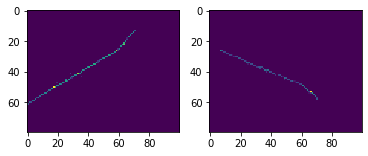

In [62]:
numu = np.where(core_labels<4)[0]
display(numu, core_maps)

#### Nu_e interaction

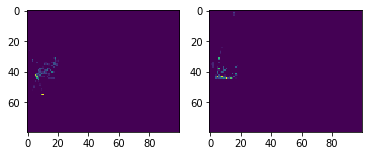

In [132]:
rest = np.where(core_labels>=4)[0]
nue = np.where(core_labels[rest]<8)[0]
display(nue, core_maps)

#### NC interaction

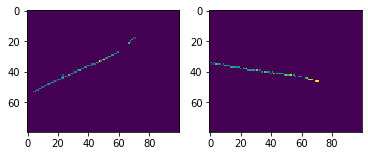

In [96]:
rest = np.where(core_labels>=12)
nc = np.where(core_labels<=13)[0]
display(nc, core_maps)

#### Training the model with the original data

In [ ]:
numu = np.where(core_labels<4)

In [8]:
#Normalise images
norm_maps = normalise(core_maps)
#Sort labels
sort_labels = sort(core_labels)
#Separate the 2 images
top_images, side_images = split_images(norm_maps)

In [9]:
#Create a model to be trained with the skewed data
model_skew = create_model()
#Train the model
history_skew = model_skew.fit([top_images, side_images], sort_labels, epochs = 20, verbose =2, validation_split = 0.2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 100, 80, 16)  160         input_2[0][0]                    
____________________________________________________________________________________________

#### Training the test model with the unskewed data 

In [3]:
core_labels, core_maps, core_nu_energy, core_lep_energy = data_retriever(20) # call in the first 20 files
print('Original labels are of the shape ' , core_labels.shape) 
print('Original Images are of the shape ' , core_maps.shape) 

100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Original labels are of the shape  (131916, 1)
Original Images are of the shape  (131916, 2, 100, 80)


In [4]:
labels =sort(core_labels) # sort labels so its a binary dataset

# Find position of muon neutrino events
ones = np.where(labels == 1) 

# Find percentage of muon neutrino events
perc = 100*len(ones[0])/len(labels) 
print('The original data consisted of '+'{:.2f}'.format(perc)+'% of muon neutrino interactions')

The original data consisted of 88.09% of muon neutrino interactions


Text(0, 0.5, 'Number of events')

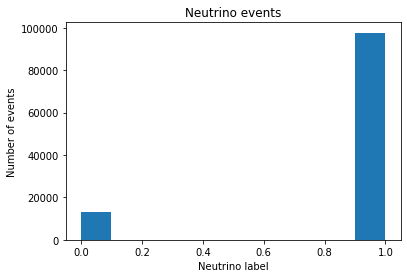

In [12]:
plt.hist(labels)
plt.title('Neutrino events')
plt.xlabel('Neutrino label')
plt.ylabel('Number of events')

In [14]:
# make labels have equal numbers of 0s and 1s and get corresponding images
sep_labels, sep_maps, sep_nue, sep_lepe = unskew(core_maps, labels, core_nu_energy, core_lep_energy)

print('Labels corrected for skewness are of the shape', sep_labels.shape)

# Find position of muon neutrino events in unskewed data
ones = np.where(sep_labels == 1)

# Find percentage of muon neutrino events in unskewed data
perc = 100*len(ones[0])/len(sep_labels) 
print('The unskewed data consists of '+'{:.2f}'.format(perc)+'% muon neutrino interactions')

#Normalise images
norm_maps = normalise(sep_maps)
#Separate the 2 images
top_images, side_images = split_images(norm_maps)

Labels corrected for skewness are of the shape (26344,)
The unskewed data consists of 50.00% muon neutrino interactions


In [15]:
#Normalise images
norm_maps = normalise(sep_maps)
#Separate the 2 images
top_images, side_images = split_images(norm_maps)

In [16]:
#Create a model to be trained with the skewed data
model_test = create_test_model()
#Train the model
history_test = model_test.fit([top_images, side_images], sep_labels, epochs = 20, verbose =2, validation_split = 0.2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 80, 16)  160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 100, 80, 16)  160         input_4[0][0]                    
____________________________________________________________________________________________

#### Training the final model with the unskewed data

In [17]:
#Create a model to be trained with the unskewed data
model_unskew = create_model()
#Trian the model
history_unskew = model_unskew.fit([top_images, side_images], sep_labels, epochs = 20, verbose =2, validation_split = 0.2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 100, 80, 16)  160         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 100, 80, 16)  160         input_6[0][0]                    
____________________________________________________________________________________________

In [133]:
from keras.models import load_model
model = load_model('model_unskew')
model_skew = load_model('model_skew')

#### Determining which model to use

Firstly, we will need to import a file from the NOvA experiments to use as testing data.

In [19]:
#Call in test file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino100.h5', "neutrino100.h5")

df=h5py.File('neutrino100.h5','r')
test_labels = np.array(df['neutrino']['interaction'])
test_maps = np.array(df['cvnmap'])

test_labels = sort(test_labels)

test_maps = test_maps.reshape(((test_maps.shape[0],2,100,80)))

#Normlaise test maps
test_maps_norm= normalise(test_maps)

#Separate the 2 normlaised images
top_test_images, side_test_images= split_images(test_maps_norm) 

#### Analysing the model trained with the original skewed data

In [20]:
skew_preds = model_skew.predict([top_test_images, side_test_images])

# Use predicitons to claculate and print the f1 and auroc metrics for skewed model
print('skew_f1 = ', f1_score(test_labels, np.round(skew_preds),average = 'binary'))
print('skew_auroc = ', roc_auc_score(test_labels, np.round(skew_preds),average = 'micro'))
#plot_loss(history_skew)

skew_f1 =  0.940262047523873
skew_auroc =  0.5


#### Analysing one of the test models trained with the unskewed data

f1 score for test model=  0.8936676583085424
over_roc for test_model=  0.8165979774282539


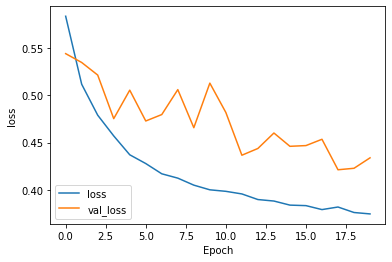

In [21]:
test_preds = model_test.predict([top_test_images, side_test_images])
print('f1 score for test model= ', f1_score(test_labels, np.round(test_preds),average = 'binary'))
print('over_roc for test_model= ', roc_auc_score(test_labels, np.round(test_preds),average = 'micro'))
plot_loss(history_test)

#### Analysing the final model trained with the unskewed data

In [22]:
unskew_preds = model.predict([top_test_images, side_test_images])
orig_f1 = f1_score(test_labels, np.round(unskew_preds),average = 'binary')
orig_auroc = roc_auc_score(test_labels, np.round(unskew_preds))
# Use predicitons to claculate and print the f1 and auroc metrics for unskewed model
print('unskew_f1 = ', orig_f1)
print('unskew_auroc = ', orig_auroc)
#plot_loss(history_unskew)

unskew_f1 =  0.8861586046911247
unskew_auroc =  0.8248342473362799


## Testing against other hyperparameters

Defining some functions that will help sort the images and labels corresponding to different sets of metadata.

In [135]:
def sort_quality(labels, maps):
    '''
    Function to change label array to be binary. 
    1 represents an mu neutino interaction 
    and 0 represents non mu neutrino interactions. 
    Also sorts labels and images into QE and DIS groups
    '''
    dis_maps = []
    qe_maps = []
    dis_labels = []
    qe_labels = []
    numu_interaction = []
    for i in range(labels.shape[0]):
        lab = labels[i]
        
        if labels[i]<4:#Select only datapoints which correspond to mu neutrino interactions
            if labels[i] == 0:
                qe_labels.append(1)
                qe_maps.append(maps[i])
            elif labels[i] == 2:
                dis_labels.append(1)
                dis_maps.append(maps[i])
                
        elif labels[i]>=4 and labels[i] <8:#Select datapoints which correspond to electron neutrino interactions
            if labels[i] == 4:
                qe_labels.append(0)
                qe_maps.append(maps[i])
            elif labels[i] == 6:
                dis_labels.append(0)
                dis_maps.append(maps[i])
                
        elif labels[i]>=8 and labels[i] <12:#Select datapoints which correspond to tau neutrino interactions
            if labels[i] == 8:
                qe_labels.append(0)
                qe_maps.append(maps[i])
            elif labels[i] == 10:
                dis_labels.append(0)
                dis_maps.append(maps[i])
                
    dis_maps = np.array(dis_maps)
    qe_maps = np.array(qe_maps)
    dis_labels = np.array(dis_labels)
    qe_labels = np.array(qe_labels)
    
    
    return qe_maps, qe_labels, dis_maps, dis_labels

def sort_energy(labels, maps, energy):
    ''' 
    Sorts labels and maps into high and low enegy
    groups. The enrgy threshold has been determined to be 
    half of the maximum energy value
    '''
    
    low_labels = []
    low_maps = []

    medlow_labels = []
    medlow_maps = []
    
    medhigh_labels = []
    medhigh_maps = []
    
    high_labels = []
    high_maps = []

    numu_interaction = []
    
    low = energy.min()
    med_low = np.quantile(energy, .25)
    med = np.quantile(energy, .50)
    med_high = np.quantile(energy, .75)
    high = energy.max()
    
    for i in range(energy.shape[0]):
        #Append to low energy arrays when energy is lower than the threshold
        if energy[i]<med_low and energy[i]>=low: 
            low_maps.append(maps[i])
            low_labels.append(labels[i])
            
        if energy[i]<med and energy[i]>=med_low: 
            medlow_maps.append(maps[i])
            medlow_labels.append(labels[i])
        
        if energy[i]<med_high and energy[i]>=med: 
            medhigh_maps.append(maps[i])
            medhigh_labels.append(labels[i])
            
        elif energy[i]>=med_high:
            high_maps.append(maps[i])
            high_labels.append(labels[i])
        
    #convert lists to numpy accuracies 
    high_maps = np.array(high_maps)
    high_labels = np.array(high_labels)
    
    medhigh_maps = np.array(medhigh_maps)
    medhigh_labels = np.array(medhigh_labels)
    
    medlow_maps = np.array(medlow_maps)
    medlow_labels = np.array(medlow_labels)
    
    low_maps = np.array(low_maps)
    low_labels = np.array(low_labels)
    
    return low_labels, low_maps, medlow_labels, medlow_maps, medhigh_labels, medhigh_maps, high_labels, high_maps

def evaluate(labels, images):
    '''
    Function to return predictions from model 
    given input labels and images
    '''
    
    top_images = images[:,0] 
    side_images = images[:,1]
    
    #Add channel dimension to the images
    top_images = np.expand_dims(top_images,axis=3)
    side_images = np.expand_dims(side_images,axis=3)
    
    #Run the model
    preds = np.round(model.predict([top_images, side_images]))
    
    return preds

#### Testing agaisnt qe/dis

In [136]:
#Organise data for QE and DIS events
qe_maps, qe_labels, dis_maps, dis_labels = sort_quality(core_labels, core_maps)

#Get model predictions for dis and qe events
diss_preds = evaluate(dis_labels, dis_maps)
qe_preds = evaluate(qe_labels, qe_maps)

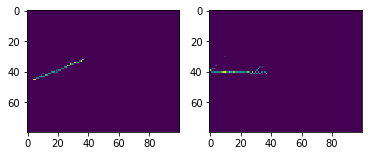

In [166]:
display(qe_labels, qe_maps)

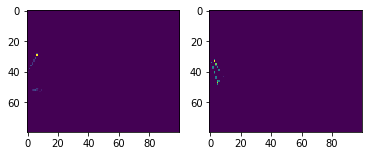

In [161]:
display(dis_labels, dis_maps)

In [25]:
f1_qe = f1_score(qe_labels, np.round(qe_preds),average = 'binary')
auroc_qe = roc_auc_score(qe_labels, np.round(qe_preds),average = 'micro')

f1_dis = f1_score(dis_labels, np.round(diss_preds),average = 'binary')
auroc_dis = roc_auc_score(dis_labels, np.round(diss_preds),average = 'micro')

f1_im = [f1_qe, f1_dis, orig_f1]
auroc_im = [auroc_qe, auroc_dis, orig_auroc]

In [26]:
print('F1 score for QE events =', f1_qe)
print('Auroc score for QE events = ', auroc_qe)
print('F1 score for DIS events =', f1_dis)
print('Auroc score for DIS events = ', auroc_dis)

F1 score for QE events = 0.9753683747525842
Auroc score for QE events =  0.8983184892391011
F1 score for DIS events = 0.8595090097379419
Auroc score for DIS events =  0.8319151425992176


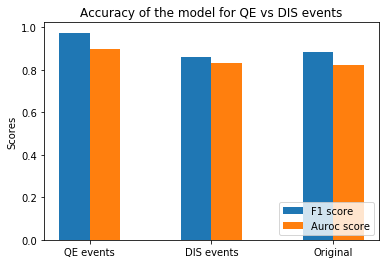

In [27]:
ind = np.arange(3)
width = 0.25
plt.bar(ind, f1_im, width, label='F1 score')
plt.bar(ind + width, auroc_im, width,
    label='Auroc score')
plt.ylabel('Scores')
plt.title('Accuracy of the model for QE vs DIS events')

plt.xticks(ind + width / 2, ('QE events', 'DIS events','Original'))
plt.legend(loc='lower right')
plt.show()

##### Testing against neutrino energies

Text(0, 0.5, 'Number of events')

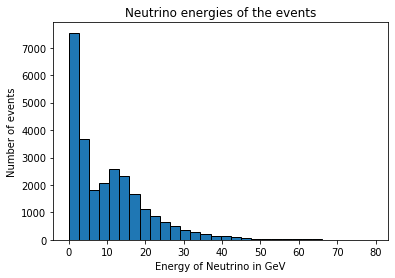

In [28]:
plt.hist(sep_nue, bins=30, edgecolor='black')

plt.title('Neutrino energies of the events')
plt.xlabel('Energy of Neutrino in GeV')
plt.ylabel('Number of events')

In [29]:
#Organise data for high and low energy neutrinos
low_nu_labels, low_nu_maps, medlow_nu_labels, medlow_nu_maps, medhigh_nu_labels, medhigh_nu_maps, high_nu_labels, high_nu_maps = sort_energy(sep_labels, sep_maps, sep_nue)

#Get model predicitions for the low and high energy neutrons
low_nu_preds = evaluate(low_nu_labels, low_nu_maps)
medlow_nu_preds = evaluate(medlow_nu_labels, medlow_nu_maps)
medhigh_nu_preds = evaluate(medhigh_nu_labels, medhigh_nu_maps)
high_nu_preds = evaluate(high_nu_labels, high_nu_maps)

In [30]:
f1_low_nue =  f1_score(low_nu_labels, np.round(low_nu_preds),average = 'binary')
auroc_low_nue = roc_auc_score(low_nu_labels, np.round(low_nu_preds),average = 'micro')

f1_medlow_nue =  f1_score(medlow_nu_labels, np.round(medlow_nu_preds),average = 'binary')
auroc_medlow_nue = roc_auc_score(medlow_nu_labels, np.round(medlow_nu_preds),average = 'micro')

f1_medhigh_nue =  f1_score(medhigh_nu_labels, np.round(medhigh_nu_preds),average = 'binary')
auroc_medhigh_nue = roc_auc_score(medhigh_nu_labels, np.round(medhigh_nu_preds),average = 'micro')

f1_high_nue =  f1_score(high_nu_labels, np.round(high_nu_preds),average = 'binary')
auroc_high_nue = roc_auc_score(high_nu_labels, np.round(high_nu_preds),average = 'micro')

f1_nue = [f1_low_nue, f1_medlow_nue, f1_medhigh_nue, f1_high_nue, orig_f1]
auroc_nue= [auroc_low_nue, auroc_medlow_nue, auroc_medhigh_nue, auroc_high_nue, orig_auroc]

In [31]:
print('F1 score for low energy neutrinos =', f1_low_nue)
print('Auroc score for low energy neutrinos= ',auroc_low_nue)

print('F1 score for medium low energy neutrinos =', f1_medlow_nue)
print('Auroc score for medium low energy neutrinos= ', auroc_medlow_nue)

print('F1 score for medium high energy neutrinos =', f1_medhigh_nue)
print('Auroc score for medium high energy neutrinos = ',auroc_medhigh_nue)

print('F1 score for high energy neutrinos =', f1_high_nue)
print('Auroc score for high energy neutrinos = ',auroc_high_nue)

F1 score for low energy neutrinos = 0.8064516129032259
Auroc score for low energy neutrinos=  0.8156819076004191
F1 score for medium low energy neutrinos = 0.8321364452423698
Auroc score for medium low energy neutrinos=  0.8295569138507668
F1 score for medium high energy neutrinos = 0.8253497942386832
Auroc score for medium high energy neutrinos =  0.8371276630136101
F1 score for high energy neutrinos = 0.8464033018867925
Auroc score for high energy neutrinos =  0.8479431457336736


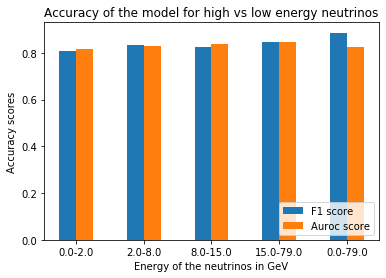

In [32]:
low = np.round(sep_nue.min())
med_low = np.round(np.quantile(sep_nue, .25))
med = np.round(np.quantile(sep_nue, .50))
med_high = np.round(np.quantile(sep_nue, .75))
high = np.round(sep_nue.max())

low_bound = str(low)+'-'+str(med_low)
medlow_bound = str(med_low)+'-'+str(med)
medhigh_bound = str(med)+'-'+str(med_high)
high_bound = str(med_high)+'-'+str(high)
total = str(low)+'-'+str(high)

ind = np.arange(5)
width = 0.25
plt.bar(ind, f1_nue, width, label='F1 score')
plt.bar(ind + width, auroc_nue, width,
    label='Auroc score')
plt.ylabel('Accuracy scores')
plt.xlabel('Energy of the neutrinos in GeV')
plt.title('Accuracy of the model for high vs low energy neutrinos')

plt.xticks(ind + width / 2, (low_bound, medlow_bound,medhigh_bound, high_bound,total))
plt.legend(loc='lower right')
plt.show()

##### Testing against lepton energies

In [34]:
#Organise data for high and low energy leptons
low_lep_labels, low_lep_maps, medlow_lep_labels, medlow_lep_maps, medhigh_lep_labels, medhigh_lep_maps, high_lep_labels, high_lep_maps = sort_energy(sep_labels, sep_maps, sep_lepe)

#Get model predicitions for the low and high energy leptons
low_lep_preds = evaluate(low_lep_labels, low_lep_maps)
medlow_lep_preds = evaluate(medlow_lep_labels, medlow_lep_maps)
medhigh_lep_preds = evaluate(medhigh_lep_labels, medhigh_lep_maps)
high_lep_preds = evaluate(high_lep_labels, high_lep_maps)

In [43]:
f1_low_lep = f1_score(low_lep_labels, np.round(low_lep_preds),average = 'binary')
auroc_low_lep = roc_auc_score(low_lep_labels, np.round(low_lep_preds),average = 'micro')

f1_medlow_lep = f1_score(medlow_lep_labels, np.round(medlow_lep_preds),average = 'binary')
auroc_medlow_lep = roc_auc_score(medlow_lep_labels, np.round(medlow_lep_preds),average = 'micro')

f1_medhigh_lep = f1_score(medhigh_lep_labels, np.round(medhigh_lep_preds),average = 'binary')
auroc_medhigh_lep = roc_auc_score(medhigh_lep_labels, np.round(medhigh_lep_preds),average = 'micro')

f1_medhigh_lep = f1_score(high_lep_labels, np.round(high_lep_preds),average = 'binary')
auroc_medhigh_lep = roc_auc_score(high_lep_labels, np.round(high_lep_preds),average = 'micro')

f1_lep = [f1_low_lep, f1_medlow_lep, f1_medhigh_lep, f1_high_lep, orig_f1]
auroc_lep= [auroc_low_lep, auroc_medlow_lep, auroc_medhigh_lep, auroc_high_lep, orig_auroc]

In [36]:
print('F1 score for high energy leptons =', f1_high_lep)
print('Auroc score for high energy leptons=',auroc_high_lep)
print('F1 score for low energy leptons =', f1_low_lep)
print('Auroc score for low energy leptons=',auroc_low_lep)

F1 score for high energy leptons = 0.9019804462271246
Auroc score for high energy leptons= 0.8817603520155476
F1 score for low energy leptons = 0.5901869158878504
Auroc score for low energy leptons= 0.6949434760596883


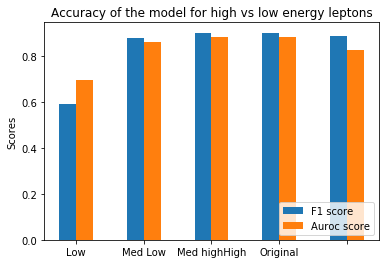

In [46]:
ind = np.arange(5)
width = 0.25
plt.bar(ind, f1_lep, width, label='F1 score')
plt.bar(ind + width, auroc_lep, width,
    label='Auroc score')
plt.ylabel('Scores')
plt.title('Accuracy of the model for high vs low energy leptons')

plt.xticks(ind + width / 2, ('Low', 'Med Low', 'Med high' 'High','Original'))
plt.legend(loc='lower right')
plt.show()

# Energy detector

In [4]:
def remove_zeros(energy, maps):
    '''
    Removes any zero energy values 
    returns non zero energies and cvnmaps
    '''

    ind = np.where(energy!=0)[0]

    energy = energy[ind]
    maps = maps[ind]
    
    return energy, maps

def balance_energy(energy, maps, n, en_max, balance = True):
    ''' 
    Sorts energy range into n even quantiles
    and then ensures each quantile has the same 
    number of data points
    
    Also takes a value en_max which inputs a limit 
    on the energies as the higher energy cases are 
    not of interest to us.
    '''

    c = 1/n
    frac = (n-1)*c
    k = 0
    
    nu_energy = []
    nu_maps =[]
    #Ensure neutrino energies are below desired max
    
    for i in range(len(energy)):
        if energy[i]<en_max:
            nu_energy.append(energy[i])
            nu_maps.append(maps[i])
        
    # Divide energies into equal quantiles
    
    en_range = [min(nu_energy), en_max] #energy range
    
    bins = []
    for j in range(n+1):
        bins.append(np.quantile(en_range,k))
        k+=c
    bins = np.array(bins)
    count = np.histogram(nu_energy, bins = bins)[0]

    num = count.min() #Number of data points in bin with the least number of entries
    
    fin_labels = []
    fin_maps = []
    
    k = 0
    for j in range(n):

        low = np.quantile(en_range, k)

        if j == n-1:            
            high = np.quantile(en_range, 1)
        else:
            high = np.quantile(en_range, c+k)
            k+=c
            
        count =0
        for i in range(len(nu_energy)):
            if balance == True:
                if count<num:
                    if nu_energy[i]<high and nu_energy[i]>=low: 
                        fin_labels.append(nu_energy[i])
                        fin_maps.append(nu_maps[i])
                        count+=1
            else:
                if nu_energy[i]<high and nu_energy[i]>=low: 
                    fin_labels.append(nu_energy[i])
                    fin_maps.append(nu_maps[i])

    fin_labels = np.array(fin_labels)
    fin_maps = np.array(fin_maps)
    
    fin_labels, fin_maps = shuffle(fin_labels, fin_maps, random_state=0) 
    bins = bins.astype(np.float32)
    
    return fin_labels, fin_maps, bins

def acc(y_true, y_pred):
    return np.average(abs((y_true-y_pred))/y_true)

def find_bias(y_true, y_pred):
    return np.average((y_true-y_pred)/y_true)

def find_res(y_true, y_pred):
    return np.std((y_true-y_pred)/y_true)

def sort(arr):
    '''
    Sorts array in ascending order
    '''
    
    x = arr.copy()
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

def fit(x, y):
    
    trend = np.polyfit(x,y,3)
    trendpoly = np.poly1d(trend) 
    
    return trendpoly

def osc_inten(core_labels, core_maps, core_nue, en_max = 80):
    '''
    Find associated energies of muon and electron neutrinos individually
    '''
    
    vals = np.where(core_nue<en_max)[0]
    
    labels = []
    nu_e = []
    maps = []
    
    for i in vals:
        labels.append(core_labels[i])
        nu_e.append(core_nue[i])
        maps.append(core_maps[i])
        
    labels = np.array(labels)
    
    ones = np.where(labels<4)[0]
    zeros = np.where(labels>=4)[0]
    
    mu_maps = []
    mu_nue = []

    for i in ones:
        mu_maps.append(maps[i])
        mu_nue.append(nu_e[i])
    
    e_maps = []
    e_nue = []

    for i in zeros:
        e_maps.append(maps[i])
        e_nue.append(nu_e[i])

    return np.array(mu_nue), np.array(mu_maps), np.array(e_nue), np.array(e_maps)

In [5]:
def create_cnn2(img):
    '''
    Create a convolution neural network that uses takes an image of shape (100,80,1) as the input.
    The image is passed as the input of the cnn using functional api
    '''
    
    model = Conv2D(16, (3, 3), padding ='same', activation = 'relu', input_shape=(100,80,1))(img)
    model = MaxPooling2D((2, 2),padding='same')(model)

    
    model = Conv2D(32, (3, 3),padding ='same',activation = 'relu')(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
    model = Conv2D(64, (3, 3),padding ='same',activation = 'relu')(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
    model = Conv2D(64, (3, 3),padding ='same',activation = 'relu')(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)


    return model

def baseline_model():
    
    #Defining input tensors 
    #Here Input is tf.keras.Input() which creates a keras tensor 
    top_input = Input(shape = (100,80,1))
    side_input = Input(shape = (100,80,1))

    #Define models based on above inputs
    model1 = create_cnn2(top_input)
    model2 = create_cnn2(side_input)

    conv = concatenate([model1,model2]) #Merging the 2 models

    conv= Flatten()(conv) #Flatten merged models
    
    dense = Dense(32, activation = 'relu')(conv)
    dense = Dropout(0.5)(dense)
    dense = Dense(16, activation = 'relu')(conv)
    dense = Dropout(0.5)(dense)
    dense = Dense(16, activation = 'relu')(conv)
    dense = Dropout(0.5)(dense)
    
    output = Dense(1, activation = 'linear')(dense) 

    model = Model(inputs=[top_input, side_input], outputs=[output])

    model.compile(loss=['mean_squared_error'],
                    optimizer=Adam(lr=0.0001)
                 )
    
    return model

In [6]:
def check_acc(model):
    
    scaler = MinMaxScaler()
    
    i = random.randint(30,80)
    #Call in test file
    file_name = 'test_file ('+str(i)+').h5'
    df=h5py.File(file_name,'r') #load file

    label = np.array(df['rec.training.trainingdata'].get('interaction'))
    test_maps = np.array(df.get('rec.training.cvnmaps').get('cvnmap'))
    energy = np.array(df['rec.training.trainingdata'].get('nuenergy'))
    lep_energy = df['rec.training.trainingdata'].get('lepenergy')
    maps = test_maps.reshape(((test_maps.shape[0],2,100,80)))

    #Remove zeros from the neutrino energies
    energy, maps = remove_zeros(energy, maps)

    #Balance energy distribution and set energy maximum to 10 
    test_bal_labels, test_bal_maps, bins = balance_energy(energy,maps,5,5)
    
    
    #Normlaise test maps
    test_maps_norm= normalise(test_bal_maps) 
    
    accs = [] 
    biases = []
    
    normalized_energy = scaler.fit_transform(test_bal_labels)
    
    for i in range(len(bins)-1):
        
        low = bins[i]
        high = bins[i+1]
        
        fin_labels = []
        fin_maps =[]
        
        for j in range(len(test_bal_labels)):  
            if test_bal_labels[j]<high and test_bal_labels[j]>=low: 
                fin_labels.append(test_bal_labels[j])
                fin_maps.append(test_maps_norm[j])
        
        fin_labels = np.array(fin_labels)
        fin_maps = np.array(fin_maps)
        
        #Separate the 2 normalised images
        top_test_images, side_test_images= split_images(fin_maps)
        preds = model.predict([top_test_images, side_test_images])
        energy_preds = scaler.inverse_transform(preds)
        accs.append(find_res(fin_labels,energy_preds))
        biases.append((find_bias(fin_labels,energy_preds)))
        
    bins = bins.astype(np.float32)
    
    return accs, biases, bins


In [7]:
core_labels, core_maps, core_nu_energy, core_lep_energy = data_retriever(20) 
print('Original labels are of the shape ' , core_labels.shape) 
print('Original Images are of the shape ' , core_maps.shape) 

100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Original labels are of the shape  (131916, 1)
Original Images are of the shape  (131916, 2, 100, 80)


Text(0, 0.5, 'Intensity')

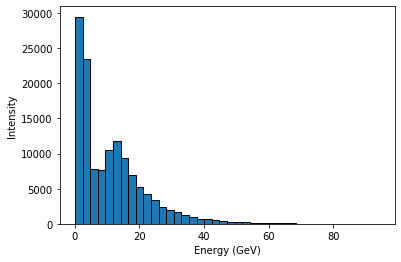

In [8]:
plt.hist(core_nu_energy, bins =40, edgecolor = 'black', )
plt.xlabel('Energy (GeV)')
plt.ylabel('Intensity')

In [9]:
#Remove zeros from the neutrino energies
nu_energy, maps = remove_zeros(core_nu_energy, core_maps)

#Balance energy distribution and set energy maximum to 10 
cut_labels, cut_maps, bins = balance_energy(nu_energy,maps,5,5, balance = False)

#Balance energy distribution and set energy maximum to 10 
bal_labels, bal_maps, bins1 = balance_energy(nu_energy,maps,5,5)

In [52]:
scaler = MinMaxScaler()

#Normalise images
norm_maps = normalise(cut_maps)
#Separate the 2 images
top_images, side_images = split_images(norm_maps)
# fit and transform in one step
normalized_energy = scaler.fit_transform(cut_labels)

#Normalise images
norm_maps1 = normalise(bal_maps)
#Separate the 2 images
top_images1, side_images1 = split_images(norm_maps1)
# fit and transform in one step
normalized_energy1 = scaler.fit_transform(bal_labels)

In [53]:
# model_non = baseline_model()
# history_flav = model_non.fit([top_images, side_images], normalized_energy, epochs = 20, verbose =2, validation_split= 0.2)

In [54]:
# model_en = baseline_model()
# history_flav = model_en.fit([top_images1, side_images1], normalized_energy1, epochs = 20, verbose =2, validation_split= 0.2)

In [10]:
from keras.models import load_model

#Model with max energy =10
model_non = load_model('model_non')
model_en = load_model('model_en')

#Model with max energy = 5
model_non5 = load_model('model_non5')
model_en5 = load_model('model_en5')

## Max energy = 5

In [11]:
#Model with original dataset
res, bias, bins = check_acc(model_non5)

print('Average resolution ', np.average(res))
print('Average bias ', np.average(bias))

for i in range(len(res)):
    print("{:.2f}".format(bins[i]),': {:.2f}'.format(bins[i+1]), 'has a resolution of {:.2f}'.format(res[i]), 'and a bias of {:.2f}'.format(bias[i]))

Average resolution  0.28916292584671843
Average bias  -0.14094794633237856
0.43 : 1.34 has a resolution of 0.71 and a bias of -1.16
1.34 : 2.26 has a resolution of 0.28 and a bias of -0.28
2.26 : 3.17 has a resolution of 0.18 and a bias of 0.05
3.17 : 4.09 has a resolution of 0.15 and a bias of 0.27
4.09 : 5.00 has a resolution of 0.13 and a bias of 0.42


In [12]:
#Model with smeared dataset
res1, bias1, bins1 = check_acc(model_en5)

print('Average resolution ', np.average(res1))
print('Average bias ', np.average(bias1))

for i in range(len(res1)):
    print("{:.2f}".format(bins1[i]),': {:.2f}'.format(bins1[i+1]), 'has a resolution of {:.2f}'.format(res1[i]),'and a bias of {:.2f}'.format(bias1[i]))

Average resolution  0.29441893408586106
Average bias  -0.1971777499571518
0.53 : 1.42 has a resolution of 0.64 and a bias of -1.14
1.42 : 2.32 has a resolution of 0.30 and a bias of -0.33
2.32 : 3.21 has a resolution of 0.22 and a bias of -0.04
3.21 : 4.11 has a resolution of 0.17 and a bias of 0.17
4.11 : 5.00 has a resolution of 0.14 and a bias of 0.35


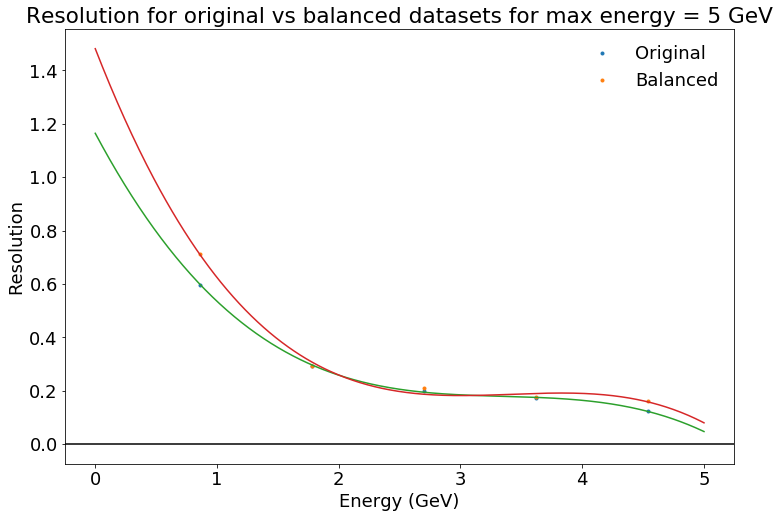

In [24]:
plt.figure()
plt.title('Resolution for original vs balanced datasets for max energy = 5 GeV')

x = []
for i in range(len(bins)-1):
    x.append((bins[i]+bins[i+1])/2)

plt.axhline(y=0, color='black', linestyle='-')

q = np.linspace(0,5,500)

plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')

#Plotting points
plt.plot(x, res, '.', label='Original')
plt.plot(x, res1, '.', label = 'Balanced')

#Fitting curves
fit_res5 = fit(x,res)
fit_res15 = fit(x,res1)

plt.plot(q, fit_res5(q))
plt.plot(q, fit_res15(q))

plt.legend()

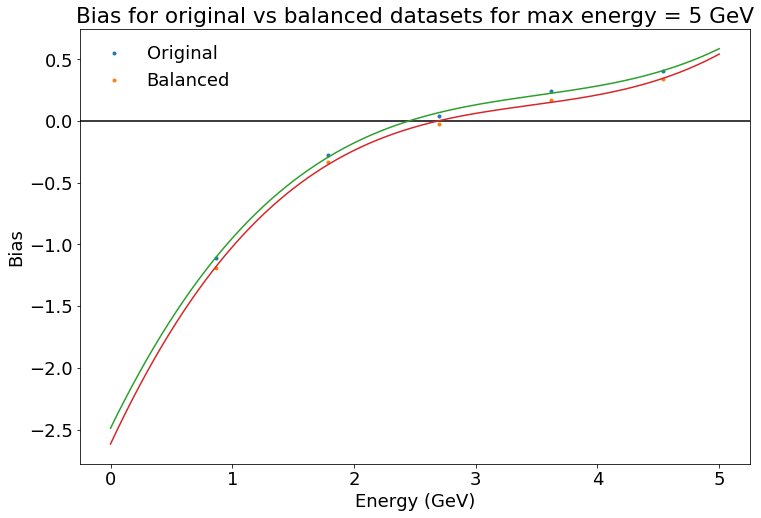

In [25]:
plt.figure()
plt.title('Bias for original vs balanced datasets for max energy = 5 GeV')

plt.axhline(y=0, color='black', linestyle='-')
plt.plot(x, bias, '.', label='Original')
plt.plot(x, bias1, '.', label = 'Balanced')

plt.xlabel('Energy (GeV)')
plt.ylabel('Bias')

#Fitting curves
fit_bias5 = fit(x,bias)
fit_bias15 = fit(x,bias1)

plt.plot(q, fit_bias5(q))
plt.plot(q, fit_bias15(q))

plt.legend()

## Max energy = 10

In [60]:
#Model with original dataset

res, bias, bins = check_acc(model_non)

print('Average resolution is ', np.average(res))

for i in range(len(res)):
    print("{:.2f}".format(bins[i]),': {:.2f}'.format(bins[i+1]), 'has a relative error of {:.2f}'.format(res[i]), 'and a bias of {:.2f}'.format(bias[i]))

Average resolution is  0.36493306758216715
0.35 : 2.28 has a relative error of 0.74 and a bias of -0.96
2.28 : 4.21 has a relative error of 0.41 and a bias of -0.25
4.21 : 6.14 has a relative error of 0.27 and a bias of 0.19
6.14 : 8.07 has a relative error of 0.22 and a bias of 0.40
8.07 : 10.00 has a relative error of 0.19 and a bias of 0.49


In [61]:
#Model with smeared dataset

res1, bias1, bins1 = check_acc(model_en)

print('Average relative error is ', np.average(res1))
for i in range(len(res1)):
    print("{:.2f}".format(bins1[i]),': {:.2f}'.format(bins1[i+1]), 'has a relative error of {:.2f}'.format(res1[i]),'and a bias of {:.2f}'.format(bias1[i]))

Average relative error is  0.38627377744923935
0.45 : 2.36 has a relative error of 0.89 and a bias of -1.68
2.36 : 4.27 has a relative error of 0.41 and a bias of -0.72
4.27 : 6.18 has a relative error of 0.27 and a bias of -0.03
6.18 : 8.09 has a relative error of 0.20 and a bias of 0.19
8.09 : 10.00 has a relative error of 0.16 and a bias of 0.35


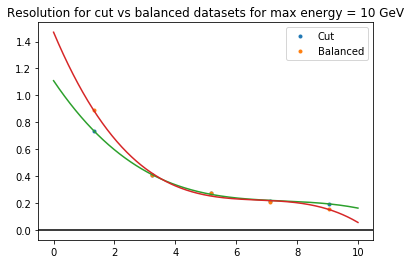

In [62]:
plt.figure()
plt.title('Resolution for cut vs balanced datasets for max energy = 10 GeV')

x = []
for i in range(len(bins)-1):
    x.append((bins[i]+bins[i+1])/2)
    
q = np.linspace(0,10,500)

plt.axhline(y=0, color='black', linestyle='-')

#Plotting points
plt.plot(x, res, '.', label='Cut')
plt.plot(x, res1, '.', label = 'Balanced')

#Fitting curves
fit_res = fit(x,res)
fit_res1 = fit(x,res1)

plt.plot(q, fit_res(q))
plt.plot(q, fit_res1(q))

plt.legend()

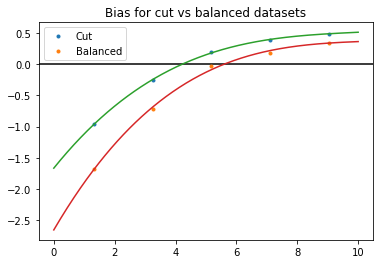

In [63]:
plt.figure()
plt.title('Bias for cut vs balanced datasets')

plt.axhline(y=0, color='black', linestyle='-')
plt.plot(x, bias, '.', label='Cut')
plt.plot(x, bias1, '.', label = 'Balanced')

#Fitting curves
fit_bias = fit(x,bias)
fit_bias1 = fit(x,bias1)

plt.plot(q, fit_bias(q))
plt.plot(q, fit_bias1(q))

plt.legend()

### Oscillation sensitivities

In [16]:
#The following libraries were imported from R. Nichol, “Pyosccalc,” https://github.com/nichol77/PyOscCalc, 2020.
31


from OscCalc import OscCalc
import FluxTools as ft
from FitTools import FitTools
calcy = OscCalc()
ft2 = ft.FluxTools()

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 18})

Text(0.5, 0, 'Energy (GeV)')

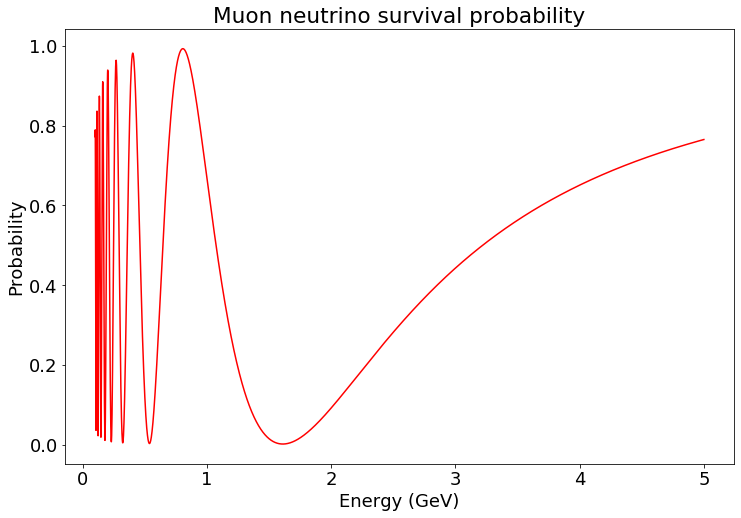

In [17]:
energyBins = np.arange(0.1,5,0.001)
muSurv = np.asarray([calcy.MuToMu(E) for E in energyBins])

fig, ax2 = plt.subplots()
ax2.set_title('Muon neutrino survival probability')
ax2.plot(energyBins, muSurv,'r-',label="e appear")
ax2.set_ylabel('Probability')
ax2.set_xlabel('Energy (GeV)')

2.452239 0.8702307


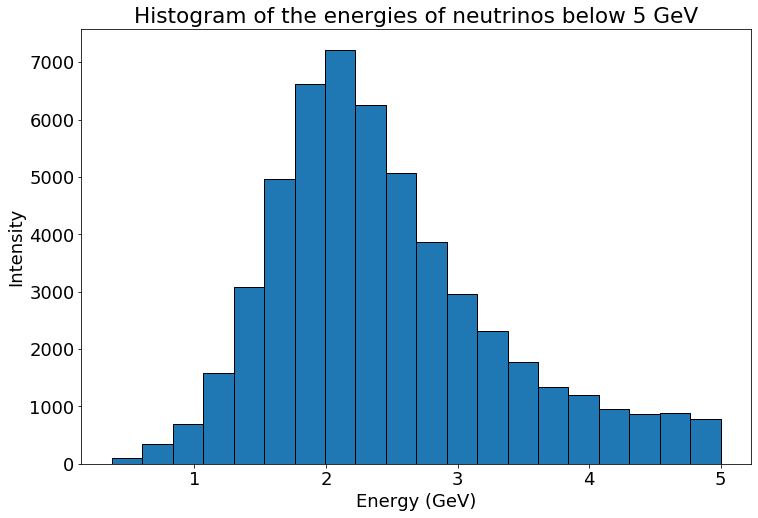

In [26]:
plt.hist(cut_labels, bins = 20, edgecolor='black')
plt.title('Histogram of the energies of neutrinos below 5 GeV')
plt.xlabel('Energy (GeV)')
plt.ylabel('Intensity')
print(np.mean(cut_labels), np.std(cut_labels))
num, bin_edges = np.histogram(cut_labels, bins = 20)

In [27]:
# Smearing the data

smeared = np.empty((0))

for i in range(len(bin_edges)-1):
    mid = (bin_edges[i]+bin_edges[i+1])/2
    del_sd = fit_res5(mid)
    del_mu = fit_bias5(mid)

    #Find mean and sd with uncertainty

    cor_mean = mid-del_mu

    sd = 0.8702307 # standard deviation of true data
    cor_sd = sd+del_sd


    a = np.random.normal(cor_mean, cor_sd,num[i])
    smeared = np.append(smeared, a, axis =0)

Text(0, 0.5, 'Intensity')

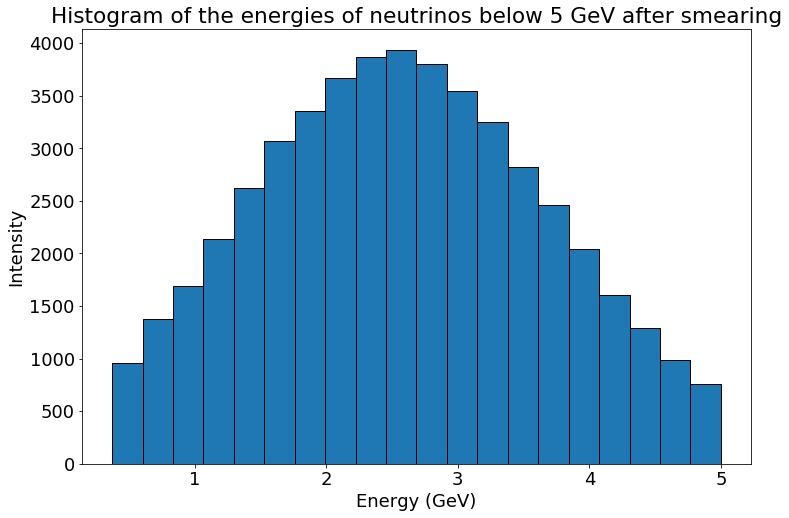

In [28]:
plt.hist(smeared, bins = bin_edges, edgecolor = 'black' )

plt.title('Histogram of the energies of neutrinos below 5 GeV after smearing')
plt.xlabel('Energy (GeV)')
plt.ylabel('Intensity')

139.94303688911086


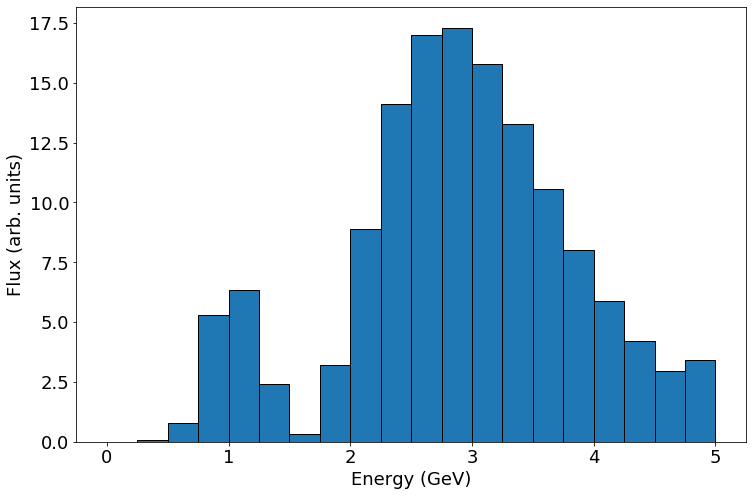

In [29]:
ln = ft.LogNormalFlux() # tweak this to match data
pdf=ft2.pdfwrap(ln)
binVals=ft2.getNuMuAsimov(ln, calcy) # calcy  = oscialltion calculator 
binEdges=ft2.binEdges
print(sum(binVals))
#Finally plot the fluxes
fig, ax4 = plt.subplots(1, 1)
ax4.hist(binEdges[:-1], binEdges,weights=binVals, edgecolor = 'black')
ax4.set_ylabel('Flux (arb. units)')
_ = ax4.set_xlabel('Energy (GeV)')
muModelVals = ft2.getNuMuAsimov(ln, calcy)

186.93863406982067


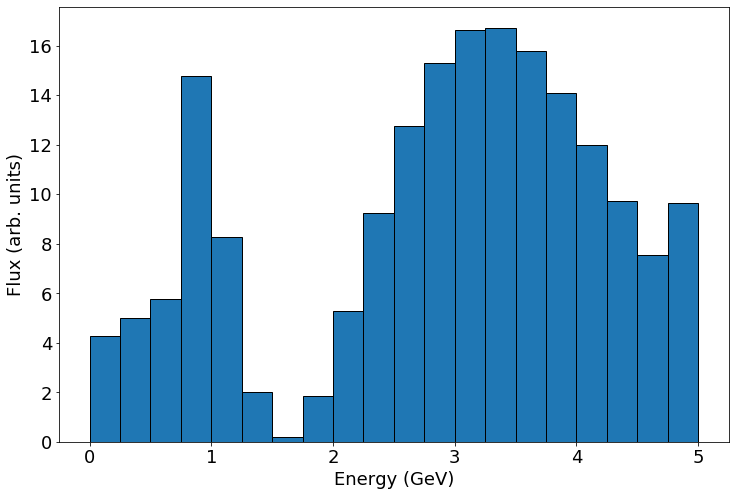

In [30]:
ln_smeared = ft.LogNormalFlux(num=num, bin_edges = bin_edges, bias = fit_bias5, resolution = fit_res5, smear = True) # tweak this to match data
pdf_smeared=ft2.pdfwrap(ln_smeared)
binVals_smeared=ft2.getNuMuAsimov(ln_smeared, calcy) # calcy  = oscialltion calculator 
binEdges_smeared=ft2.binEdges
print(sum(binVals_smeared))
#Finally plot the fluxes
fig, ax4 = plt.subplots(1, 1)
ax4.hist(binEdges_smeared[:-1], binEdges_smeared,weights=binVals_smeared, edgecolor = 'black')
ax4.set_ylabel('Flux (arb. units)')
_ = ax4.set_xlabel('Energy (GeV)')
muModelVals_smeared = ft2.getNuMuAsimov(ln_smeared, calcy)

In [68]:
def llmap(ln,calcy, muModelVals):
    
    dm32Array=np.linspace(2.2e-3,2.6e-3,num=10)
    sinSq23Array=np.linspace(0.35,0.65,12)
    dcpArray=np.linspace(0,2*math.pi,6)
    asimovArray=ft2.makeNuMuAsimovArray(ln,calcy,dm32Array,sinSq23Array,dcpArray)

    muLLArray = [[[FitTools.getPoissonLL(asimov,muModelVals) for asimov in asimovRow] for asimovRow in asimovMat] for asimovMat in asimovArray]
    
    fig, ax = plt.subplots(1, 1)
    outArr1 = FitTools.profile3Dto2D(muLLArray,[2,1])
    #print(outArr)
    im=ax.matshow(outArr1)
    cb = fig.colorbar(im)
    #cb.ax.tick_params(labelsize=12)
    ax.set_title('Likelihood Surface', fontsize=22);
    dmLabel = [float('%.2g' % dm) for dm in dm32Array]
    sinSqLabel = [float('%.2g' % dm) for dm in sinSq23Array]

    ax.set_xticks(np.arange(len(sinSqLabel)))
    ax.set_yticks(np.arange(len(dmLabel)))
    ax.set_yticklabels(dmLabel)
    ax.set_xticklabels(sinSqLabel)
    ax.set_xlabel(r'$\sin^2 {\theta}_{23}$',labelpad=10)
    ax.set_ylabel(r'$\Delta {m}^2_{32}$',labelpad=10)
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # Rotate and align bottom ticklabels
    _ = plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=90,
             ha="right")
    
    dmLLArray=FitTools.profile3Dto1D(muLLArray,2)
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(dm32Array, dmLLArray,'black', lw=5, alpha=0.6, label=r'\delta_{CP}')
    ax1.set_ylabel('LL')
    ax1.set_xlabel('delta m2')
    
    fig, ax2 = plt.subplots(1, 1)
    sinLLArray=FitTools.profile3Dto1D(muLLArray,1)
    ax2.plot(sinSq23Array, sinLLArray,'black', lw=5, alpha=0.6, label=r'\delta_{CP}')
    ax2.set_ylabel('LL')
    ax2.set_xlabel('sin2 theta')

(2, 0, 1)
(1, 2, 0)


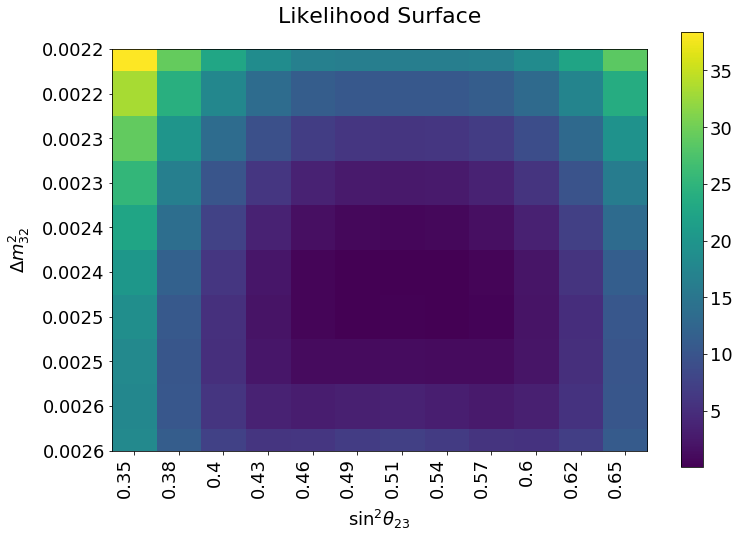

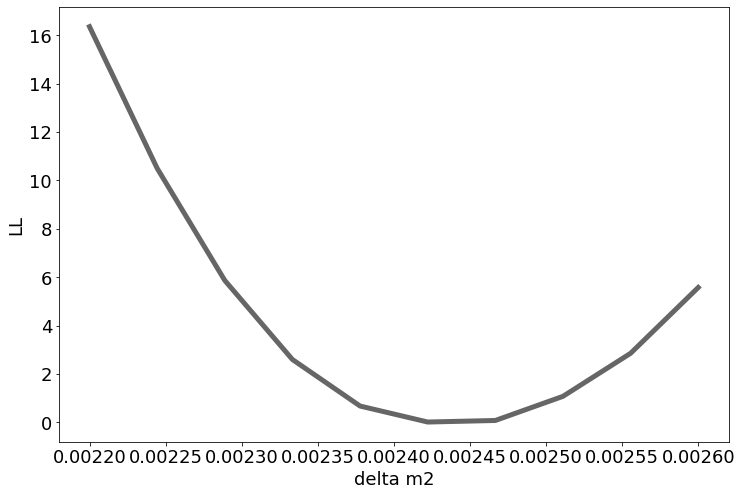

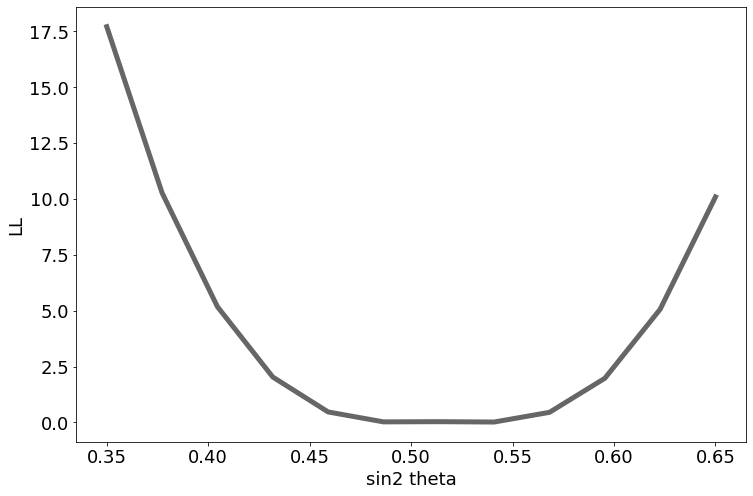

In [69]:
llmap(ln,calcy, muModelVals)

(2, 0, 1)
(1, 2, 0)


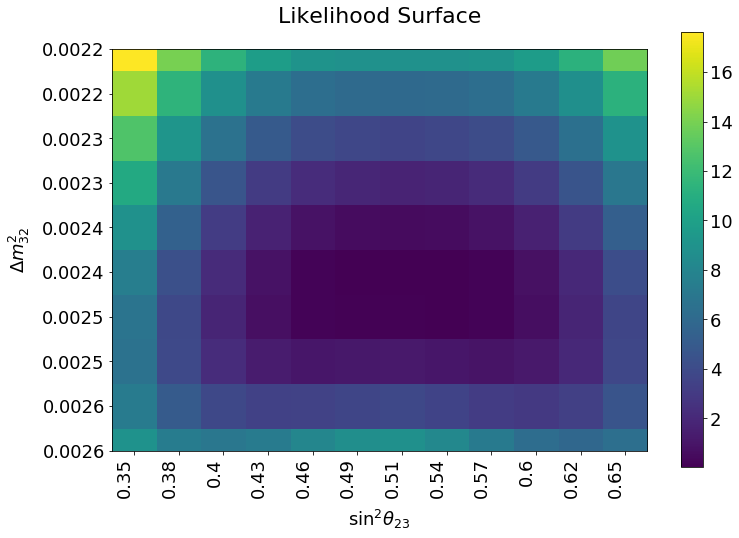

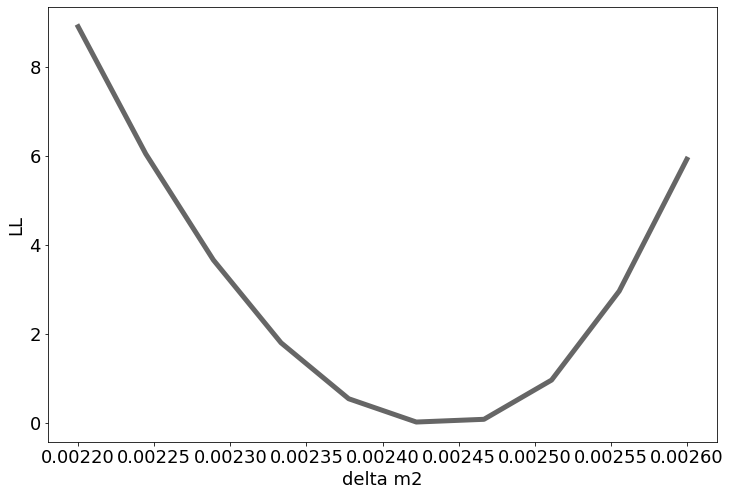

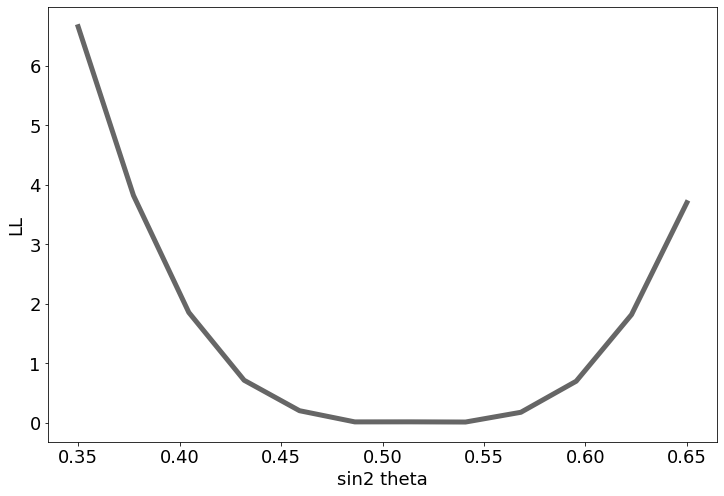

In [71]:
llmap(ln_smeared,calcy, muModelVals_smeared)